In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-08-31_19-46_20180601_20191231_rsi80.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.14404553415061297

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

NQ       0.25
GC       0.25
YM       0.25
ES       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    27722.30
GC     1659.56
NQ    27650.60
YM    27623.20
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

84655.65999999999

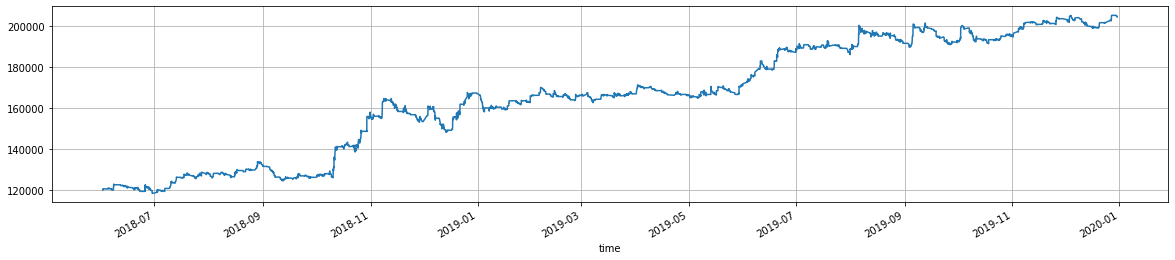

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     663
 GC    1183
 NQ    2064
 YM     658
 Name: action, dtype: int64,
 4568)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.609223
 GC    2.871359
 NQ    5.009709
 YM    1.597087
 Name: action, dtype: float64,
 11.087378640776699)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1392.30
GC    2862.86
NQ    4334.40
YM    1381.80
Name: commission, dtype: float64

In [16]:
df.commission.sum()

9971.36

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.39,2.81,413.06,-256.72,1.61,4.49,591.0
NQ,0.40,26.79,448.45,-253.40,1.77,27.34,1032.0
ES,0.40,83.75,925.63,-474.68,1.95,85.44,331.0
YM,0.43,83.96,689.38,-370.10,1.86,85.48,329.0
total,0.40,37.08,545.66,-302.47,1.80,36.78,2283.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,-0.021162,0.252760,0.480852,0.731491
GC,-0.021162,1.000000,0.126850,0.101578,0.386902
NQ,0.252760,0.126850,1.000000,0.266511,0.673947
YM,0.480852,0.101578,0.266511,1.000000,0.724605
total,0.731491,0.386902,0.673947,0.724605,1.000000


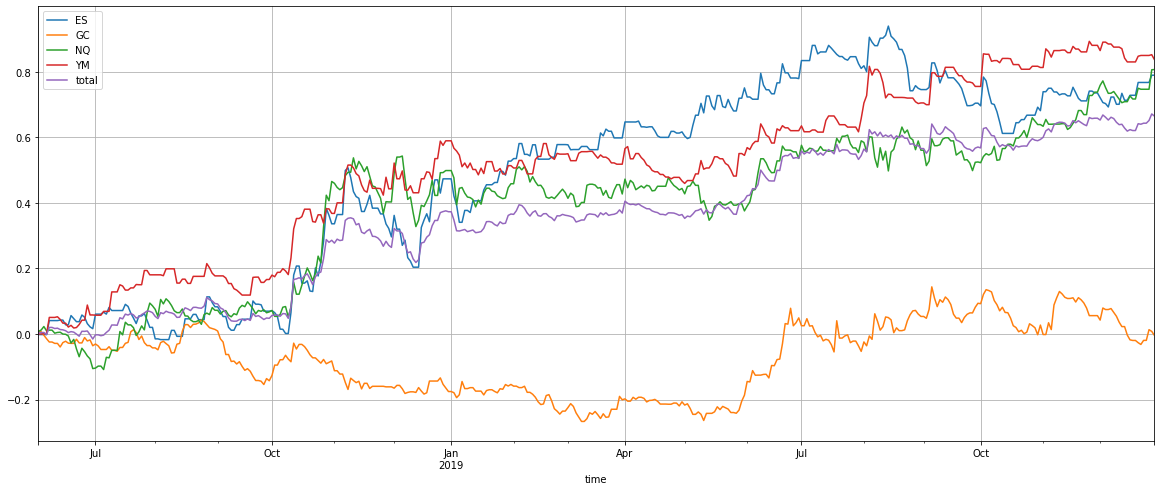

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

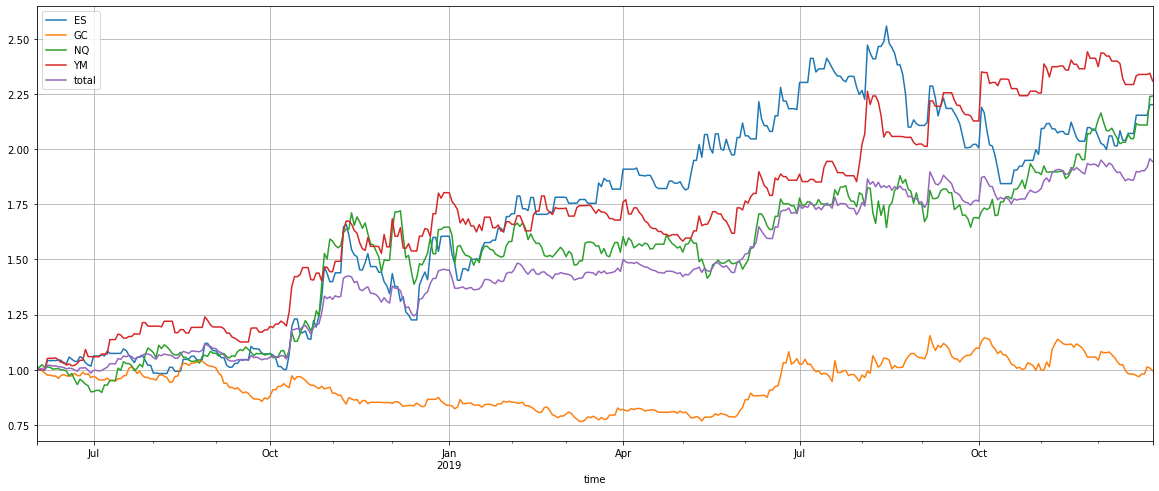

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.620438,-0.002690,0.637802,0.668216,0.501406
Cumulative returns,1.201569,-0.004394,1.240270,1.308686,0.943393
Annual volatility,0.411742,0.272829,0.376860,0.323706,0.225267
Sharpe ratio,1.372732,0.124018,1.495916,1.739824,1.915496
Calmar ratio,2.222846,-0.010105,3.294447,5.481158,3.935916
Stability,0.827992,0.115694,0.815864,0.918765,0.939316
Max drawdown,-0.279119,-0.266187,-0.193599,-0.121911,-0.127393
Omega ratio,1.353065,1.023842,1.323853,1.495102,1.471280
Sortino ratio,2.713471,0.212973,2.563574,3.665235,4.135399
Skew,1.745154,1.496985,0.782443,1.869872,2.213576


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,1.63,-3.53,-10.02,5.98,-1.52
2018-07-31,0.40,-0.65,21.11,13.02,8.38
2018-08-31,6.48,5.79,-1.36,-0.32,2.82
2018-09-30,-1.32,-14.49,-0.49,-1.10,-4.42
2018-10-31,30.53,6.22,48.86,22.34,26.88
2018-11-30,-3.91,-7.59,-6.05,7.79,-2.16
2018-12-31,19.36,-1.42,10.04,15.77,11.50
2019-01-31,5.55,2.19,-3.94,-7.30,-0.69
2019-02-28,5.18,-7.81,-2.66,3.57,-0.37


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES       120.0
GC        -0.0
NQ       124.0
YM       131.0
total     94.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2018-11-07 15:38:30,ES,SELL,2784.75,3895.8
2018-12-17 16:58:30,ES,BUY,2592.75,3858.3
2018-10-11 04:24:00,ES,BUY,2767.00,3395.8
2018-10-29 20:49:00,ES,BUY,2631.75,3195.8
2019-10-02 20:26:30,YM,BUY,26046.00,3135.8
...,...,...,...,...
2018-12-06 20:00:00,ES,BUY,2671.50,-1316.7
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.2
2018-12-07 15:39:30,ES,BUY,2701.25,-1379.2


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2018-10-11,0.120690,0.058355,0.078633,0.092773,0.087613
2019-09-05,0.077777,0.071505,0.070387,0.102387,0.080514
2019-08-05,0.110553,0.030344,0.046100,0.093553,0.070138
2018-11-07,0.143887,-0.024989,0.037107,0.091027,0.061758
2019-10-02,0.091803,0.028355,0.018967,0.104527,0.060913
...,...,...,...,...,...
2019-01-02,-0.050973,-0.003495,-0.021780,-0.022307,-0.024639
2018-11-15,-0.039447,-0.022989,-0.013367,-0.027113,-0.025729
2018-12-10,-0.051947,0.003172,-0.061173,-0.000780,-0.027682
